In [1]:
# libraries
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib
from thefuzz import fuzz, process
import googletrans
from googletrans import Translator
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Matplotlib configuration
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 16 }
plt.rc('font', **font)

# Pandas config
pd.options.mode.chained_assignment = None  # default='warn'

C:\Users\bhave\anaconda3\lib\site-packages\thefuzz\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
C:\Users\bhave\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#Taking in the input of the default training dataframe
off_df = pd.read_parquet('offers_trainingTranslated.parquet')

#Pre-processing on the training DF
off_df=off_df.dropna()
#Removing duplicates from the color column
off_df['color']=off_df['color'].apply(lambda x: ' | '.join(sorted(set(x.split(' | ')))))
off_df.head(3)

,offer_id,shop,lang,brand,color,title,description,price,url,image_urls
0,d8e0dba8-98e8-48db-9850-dd30cff374e0,aboutyou,de,PIECES,blue | light blue,Kleid,"{""material"": [""cotton""], ""sleeve length"": [""sl...",24.99,https://www.aboutyou.de/p/pieces/kleid-6732409,[https://cdn.aboutstatic.com/file/images/06728...
1,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,aboutyou,de,LASCANA,black | mixed colors,Bikinihose,"{""fitted waist"": [""super low waist""], ""brand"":...",34.90,https://www.aboutyou.at/p/lascana/bikinihose-5...,[https://cdn.aboutstatic.com/file/8ba09c163f54...
2,f0328791-9839-4bc1-ac62-78b7515e9601,aboutyou,de,MAMALICIOUS,beige,Chino-Hose,"{""brand"": [""mamalicious""], ""size run"": [""women...",21.99,https://www.aboutyou.de/p/mamalicious/chino-ho...,[https://cdn.aboutstatic.com/file/images/90ddf...


In [3]:
#There is an additional dataframe given, which contains
#matches identified by humans. we eill need that for creating our training dataframe.
match_df = pd.read_parquet('matches_training.parquet')
match_df.nunique()
match_df.head(3)

,zalando,aboutyou,brand
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,10


# Training DataFrame
## Pre-Processing

We will start by seperating the training dataframe into 'zalando' and 'aboutyou' products. this will help us in further pre-processing and understanding how many products are available for both brands 

In [4]:
#Pre-processing for 'aboutyou' dataframe
ay_df=pd.DataFrame()
ay_df=off_df.where(off_df['shop']=='aboutyou')
ay_df=ay_df.dropna()
ay_df= ay_df.drop(['lang', 'price'], axis=1)
ay_df['brand']=ay_df['brand'].str.lower()
ay_df=ay_df.reset_index().drop('index', axis=1)

#Pre-processing for 'zalando' dataframe
z_df=pd.DataFrame()
z_df=off_df.where(off_df['shop']=='zalando')
z_df=z_df.dropna()
z_df=z_df.drop(['lang', 'price'], axis=1)
z_df['brand']=z_df['brand'].str.lower()
z_df=z_df.reset_index().drop('index', axis=1)
z_df.head(3)

,offer_id,shop,brand,color,title,description,url,image_urls
0,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,zalando,guess,white,JUNIOR REVERSIBLE HOODED LONG Wintermantel,skirt_details slit pockets | decorative stones...,https://www.zalando.de/lookup/article/GU123L05...,[https://img01.ztat.net/article/1ec35ff491c54e...
1,08c47691-4160-41df-81c5-ea108f2ae539,zalando,ellesse,white,HOLLINA SHIRT & LEGGING Pyjama Nachtwäsche Set,name_suffix white $ pattern print $ material.u...,https://www.zalando.de/lookup/article/EL981P00...,[https://img01.ztat.net/article/511a8191c10549...
2,96fc5065-3a31-42f0-bfbd-34ee94324807,zalando,selected,blue,SLHSLIMMARK WASHED Businesshemd,main_supplier_code k70240 $ name_suffix dark s...,https://www.zalando.de/lookup/article/SE622D0Y...,[https://img01.ztat.net/article/4ca1292819fa35...


## Merging with match dataframe.

We merge the z_df and ay_df with the match to get the details of title and description of the products in the match df

In [5]:
#New z_df
zal_match=pd.DataFrame(columns=['zalando', 'brand'])
zal_match['zalando']=match_df['zalando']
zal_match['brand']=match_df['brand']
zal_match=zal_match.rename(columns={'zalando':'offer_id'})
z_df=z_df.merge(zal_match, on='offer_id', how='right')

#New ay_df
ay_match=pd.DataFrame(columns=['aboutyou', 'brand'])
ay_match['aboutyou']=match_df['aboutyou']
ay_match['brand']=match_df['brand']
ay_match=ay_match.rename(columns={'aboutyou':'offer_id'})
ay_df=ay_df.merge(ay_match, on='offer_id', how='right')

In [6]:
z_df=z_df.rename(columns={'offer_id':'zal_offer_id','brand_x':'brand', 'brand_y':'brand_map'})
ay_df=ay_df.rename(columns={'offer_id':'ay_offer_id','brand_x':'brand', 'brand_y':'brand_map'})
z_df=z_df.drop(columns=['shop', 'url', 'image_urls'])
z_df.head(3)

,zal_offer_id,brand,color,title,description,brand_map
0,b33f55d6-0149-4063-8b63-3eeae63562a2,swarovski,silver colored,CREATIVITY Halskette,main_supplier_code k85009 $ name_suffix silver...,10
1,f04bef4a-f771-4749-914c-1b22718523b8,swarovski,rose gold colored,LIFELONG BANGLE Armband,main_supplier_code k85009 $ name_suffix rosego...,10
2,396c292a-cda8-4477-ac67-86701fc8ab95,swarovski,silver colored,ETERNAL FLOWER BANGLE FLY Armband,main_supplier_code k85009 $ name_suffix fancy ...,10


## Similarity scores.

We will now generate the similarity scores for the products in the new dataframe. We use the fuzzywuzzy library which uses the levenshtein distance to calculate the similarity. We also use this library because it is specifically designed for the string matching purposes. We calculate scores between the 'title' and 'description' of the products

In [8]:
fuzz_score=[]
fuzz_score_1=[]
row=len(z_df)

z_df['title']=z_df['title'].values.astype('U')
ay_df['title']=ay_df['title'].values.astype('U')

z_df['description']=z_df['description'].values.astype('U')
ay_df['description']=ay_df['description'].values.astype('U')
    
#fuzz similarity
for i in range(row):
    text1 = z_df['description'][i]
    text2 = ay_df['description'][i]
    fuzz_score.append(fuzz.partial_ratio(text1, text2))  
    
#fuzz similarity title
for i in range(row):
    text1 = z_df['title'][i]
    text2 = ay_df['title'][i]
    fuzz_score_1.append(fuzz.partial_ratio(text1, text2))    

In [11]:
fuzz_score=np.array(fuzz_score)
fuzz_score=fuzz_score.reshape(15170)

fuzz_score_1=np.array(fuzz_score_1)
fuzz_score_1=fuzz_score_1.reshape(15170)

metrics_df=pd.DataFrame(data={'fuzz_score':fuzz_score, 'fuzz_score_title':fuzz_score_1})
metrics_df.to_parquet('metrics.parquet')

## NOTE
There is no need to run the above two cells, i have created a seperate parquet file called 'metrics.parquet' and i will attach it in the zip file. So you can directly run the cell below.

In [7]:
metrics_df=pd.read_parquet('metrics.parquet')

match_df=match_df.join(metrics_df,how='left')
match_df['status']=1
match_df.head(3)

,zalando,aboutyou,brand,sim_score,dis_score,fuzz_score,fuzz_score_title,status
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,10,0.069292,1.364337,12,80,1
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,10,0.081901,1.355064,3,43,1
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,10,0.043928,1.382803,4,26,1


In [8]:
print(match_df['fuzz_score'].max())
print(match_df['fuzz_score'].min())
print(match_df['fuzz_score_title'].max())
print(match_df['fuzz_score_title'].min())

67
0
100
0


## Non Match dataframe

As we need to able to train the model for non matches also, i have created a dataframe for no-matched products. I will concatenate it with the matched dataframe, to create a final Training dataframe. And later create a seperate parquet file for ease of running of code.

In [ ]:
# This is the code for creating non-match, parquet file is attached in the zip file, NO NEED TO RUN THIS BLOCK
#Code for dropping the products in the match dataframe and then creating non_match dataframe
for i in match_df['zalando']:
    z_df=z_df.drop(z_df[z_df.offer_id == i].index, inplace=False)

for j in match_df['aboutyou']:
    ay_df=ay_df.drop(ay_df[ay_df.offer_id == j].index, inplace=False)
    
#Exported the data to different parquet files to avoid computing time later.
z_df.to_parquet('z_nonmatch_df.parquet')
ay_df.to_parquet('ay_nonmatch_df.parquet')

In [9]:
non_match=pd.read_parquet('nonmatch_metrics_df.parquet')
non_match=non_match.rename(columns={'z_offer_id':'zalando', 'ay_offer_id':'aboutyou','fuzz_title_score':'fuzz_score_title'})
non_match['status']=0
non_match.head(3)

,sim_score,dis_score,fuzz_score,fuzz_score_title,zalando,aboutyou,status
0,0.071593,1.362650,2,29,02df5ca3-8adc-48fa-bf42-91b41c3ea5a9,d8e0dba8-98e8-48db-9850-dd30cff374e0,0
1,0.033150,1.390575,10,30,08c47691-4160-41df-81c5-ea108f2ae539,c0a743f8-68cf-44dc-80cf-b5edbe70ecb7,0
2,0.014478,1.403939,2,40,96fc5065-3a31-42f0-bfbd-34ee94324807,f0328791-9839-4bc1-ac62-78b7515e9601,0


## Creating the training dataframe

We have generated fuzz partial ratio scores for the products in the match dataframe. Then we created a a dataframe called the 'non_match' DF, which contains similarity score for random products from the orignal DF(excluding the ones in the match DF) to create similarity scores for the products which are not mathes

We now concatenate these dataframes to create a final DF that will be used as our training DF.

In [10]:
#This code was used to create the training dataframe.
training_df=pd.concat([match_df,non_match], axis=0)
training_df=training_df.reset_index().drop(columns=['index','brand','sim_score','dis_score'],axis=1)
training_df['fuzz_score']=training_df['fuzz_score']/100
training_df['fuzz_score_title']=training_df['fuzz_score_title']/100
#As a lot of computing power is spent everytime, we have exported it to a parquet file so that it can be easily read.
training_df.to_parquet('training_df.parquet')

In [4]:
training_df=pd.read_parquet('training_df.parquet')
training_df

,zalando,aboutyou,fuzz_score,fuzz_score_title,status
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,0.12,0.80,1
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,0.03,0.43,1
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,0.04,0.26,1
3,e72b5d05-fd06-46e9-a183-5e2e26ed18bb,22344dcd-2eca-4576-a89d-916cc47f6cb4,0.25,1.00,1
4,87b7841b-f44e-4652-ace4-2ac975510226,c2f1a132-c013-4e78-8582-6d3001e05cbf,0.02,1.00,1
...,...,...,...,...,...
30165,ea303a00-6466-41ea-803f-3f73e8203ff7,13cc7454-06e7-4ba5-ac92-5a4726f97af6,0.04,0.17,0
30166,e29cf029-244b-4e61-ad45-defdf9575856,273947f9-c3ac-4027-b61a-64a2e5502cb4,0.03,0.00,0
30167,5c76beb2-67bd-4a05-89c9-859155a0334a,63a30059-a3e1-4b0e-8e39-cc8cb674ccd0,0.17,0.40,0
30168,05dac6a8-601d-4b0d-8421-10024d70dc25,95c1008c-6aea-44a2-a82e-856a7ec897fc,0.10,0.22,0


# Test Dataframe
## Pre-Processing

For the test dataframe, we keep the pre-processing simple. We perform similar data cleaning to the training datadrame.
Then, we use a for loop to match every product, but with the same color and brand. We create similarity scores for their description and title.

Then we take the match with the maximum score to see and predict whether its a match or not in the K-Means clustering algorithm, and later the Naíve Bayes Algorithm.

In [2]:
test = pd.read_parquet("test_df.parquet")
test=test.dropna()
test['brand']=test['brand'].str.lower()
test['color']=test['color'].str.lower()
test['color']=test['color'].apply(lambda x: ' | '.join(sorted(set(x.split(' | ')))))

In [3]:
test['shop'].value_counts()

aboutyou    70090
zalando     36578
Name: shop, dtype: int64

### Seperate DataFrames
I translated the color, title and description columns of the test dataframe. And the seperated them into zalando and aboutyou dataframes. the below cell contains the sample code for the translation. 

In [ ]:
#translator=Translator()
#li2=[]

#for i in range(len(ay_test_df['color'])):
#    try:
#        test['color'][i]=translator.translate(test['color'][i], src='de', dest='en').text
#    except:
#        li2.append(i)

In [5]:
z_test_df=pd.read_parquet('z_test_1_df.parquet')
ay_test_df=pd.read_parquet('ay_test_1_df.parquet')

In [6]:
z_test_df=pd.read_parquet('z_test_1_df.parquet')
ay_test_df=test.where(test['shop']=='aboutyou').dropna()

z_test_df=z_test_df.reset_index()
ay_test_df=ay_test_df.reset_index()

z_test_df['brand']=z_test_df['brand'].str.lower()
z_test_df['title']=z_test_df['title'].str.lower()
z_test_df['description']=z_test_df['description'].str.lower()
z_test_df=z_test_df.drop(columns=['index'], axis=1)
z_test_df=z_test_df.rename(columns={'offer_id':'zal_offer_id'})

ay_test_df['brand']=ay_test_df['brand'].str.lower()
ay_test_df['title']=ay_test_df['title'].str.lower()
ay_test_df['description']=ay_test_df['description'].str.lower()
ay_test_df=ay_test_df.drop(columns=['index'], axis=1)
ay_test_df=ay_test_df.rename(columns={'offer_id':'ay_offer_id'})

z_test_df['color']=z_test_df['color'].apply(lambda x: ' | '.join(sorted(set(x.split(' | ')))))
ay_test_df['color']=ay_test_df['color'].apply(lambda x: ' | '.join(sorted(set(x.split(' | ')))))

#### Possible Matches

I have created a dataframe for possible matches using the offers_test file. I have merged it on brand and color to have better accuracy while generating similarity scores.
After writing the code, i have exported them to parquet files, and i will attach them in the zip file for faster execution. No need to run the below block


Possible Matches 1

In [6]:
# possible_matches_1=z_test_df.merge(ay_test_df, on=['brand','color'])
# possible_matches_1=possible_matches_1.assign(fuzz_score_description=0, fuzz_score_title=0)


# for i in range(2000):
#     possible_matches_1['fuzz_score_description'][i]=fuzz.partial_ratio(possible_matches_1['description_x'][i],possible_matches_1['description_y'][i])
#     possible_matches_1['fuzz_score_title'][i]=fuzz.partial_ratio(possible_matches_1['title_x'][i],possible_matches_1['title_y'][i])

# for i in range(2000,4000):
#     possible_matches_1['fuzz_score_description'][i]=fuzz.partial_ratio(possible_matches_1['description_x'][i],possible_matches_1['description_y'][i])
#     possible_matches_1['fuzz_score_title'][i]=fuzz.partial_ratio(possible_matches_1['title_x'][i],possible_matches_1['title_y'][i])

# possible_matches_1=possible_matches_1.iloc[0:4000,:]
# possible_matches_1=possible_matches_1.drop(columns=['shop_x','brand','color','title_x','title_y','description_x','shop_y','lang','description_y','price'],axis=1)
# possible_matches_1['fuzz_score_description']=possible_matches_1['fuzz_score_description']/100
# possible_matches_1['fuzz_score_title']=possible_matches_1['fuzz_score_title']/100

# possible_matches_1.to_parquet('possible_matches_1.parquet')


Possible Matches 2

In [ ]:
# possible_matches_2=z_test_df.merge(ay_test_df, on=['brand','color','title'])
# possible_matches_2

# possible_matches_2=possible_matches_2.assign(fuzz_score_description=0, fuzz_score_title=0)

# for i in range(len(possible_matches_2)):
#     possible_matches_2['fuzz_score_description'][i]=fuzz.partial_ratio(possible_matches_2['description_x'][i],possible_matches_2['description_y'][i])
    
# possible_matches_2['fuzz_score_title']=100

# print(possible_matches_2['fuzz_score_description'].max())
# print(possible_matches_2['fuzz_score_description'].min())
# possible_matches_2.to_parquet('testing_df.parquet')

In [5]:
testing=pd.read_parquet('testing_df.parquet')
testing=testing.drop(columns=['shop_x','brand','color','title','description_x','shop_y','lang','description_y','price'],axis=1)
testing['fuzz_score_description']=testing['fuzz_score_description']/100
testing['fuzz_score_title']=testing['fuzz_score_title']/100
testing.head(3)

,zal_offer_id,ay_offer_id,fuzz_score_description,fuzz_score_title
0,37d0d991-4264-4dce-9980-17bde9d7b984,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,0.01,1.0
1,a81b5fe2-97e3-48db-a9cc-782e7ad0154a,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,0.02,1.0
2,275f7ed3-8107-47f9-ade2-dc9018547ced,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,0.02,1.0


### Final testing dataset.
Here concatenate the possible matches 1 and 2 parquet files and generate a dataframe important for testing.

In [6]:
testing_1=pd.read_parquet('possible_matches_1.parquet')
testing=pd.concat([testing,testing_1], axis=0)
testing=testing.reset_index().drop(columns='index',axis=1)
testing.head()

,zal_offer_id,ay_offer_id,fuzz_score_description,fuzz_score_title
0,37d0d991-4264-4dce-9980-17bde9d7b984,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,0.01,1.0
1,a81b5fe2-97e3-48db-a9cc-782e7ad0154a,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,0.02,1.0
2,275f7ed3-8107-47f9-ade2-dc9018547ced,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,0.02,1.0
3,8cc376c8-23a7-447b-9fa0-15914bd27e09,38bae5e1-1cb0-4fd3-ab8b-397a692b7d7a,0.04,1.0
4,8cc376c8-23a7-447b-9fa0-15914bd27e09,89bc00e1-b35e-4264-b64b-9e96dcb90d12,0.04,1.0


# Training the dataset and predicting matches.
## Fitting and training the dataset.

We use the training_df that we created earlier to train the model and use the testing dataset we created to predict our matches and evaluate our model.


### K-Means Clustering

In [12]:
cluster_training_df=pd.read_parquet('training_df.parquet')
cluster_training_df.head(3)

,zalando,aboutyou,fuzz_score,fuzz_score_title,status
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,0.12,0.80,1
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,0.03,0.43,1
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,0.04,0.26,1


In [13]:
cluster_testing=pd.DataFrame()
cluster_testing=testing.drop(columns=['zal_offer_id','ay_offer_id'])
cluster_testing.head()

,fuzz_score_description,fuzz_score_title
0,0.01,1.0
1,0.02,1.0
2,0.02,1.0
3,0.04,1.0
4,0.04,1.0


No handles with labels found to put in legend.


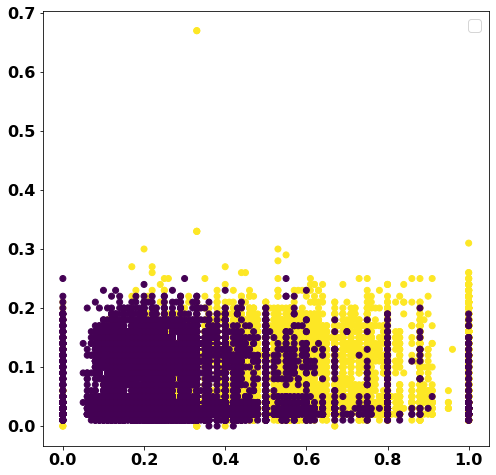

In [7]:
fig = plt.figure(figsize=(8,8))
plt.scatter(x=cluster_training_df['fuzz_score_title'], y=cluster_training_df['fuzz_score'],c=cluster_training_df['status'])
plt.legend()
plt.show()

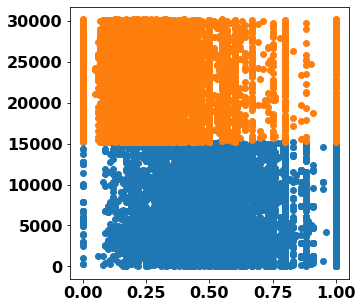

In [8]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(cluster_training_df['fuzz_score_title'].where(cluster_training_df['status']==1).dropna(), y=cluster_training_df.where(cluster_training_df['status']==1).dropna().index)
plt.scatter(cluster_training_df['fuzz_score_title'].where(cluster_training_df['status']==0).dropna(), y=cluster_training_df.where(cluster_training_df['status']==0).dropna().index)

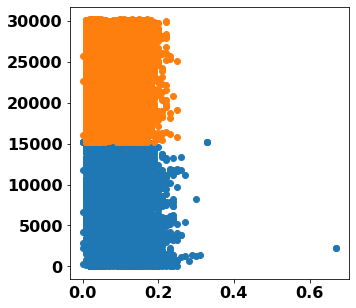

In [9]:
fig = plt.figure(figsize=(5, 5))

plt.scatter(cluster_training_df['fuzz_score'].where(cluster_training_df['status']==1).dropna(), y=cluster_training_df.where(cluster_training_df['status']==1).dropna().index)
plt.scatter(cluster_training_df['fuzz_score'].where(cluster_training_df['status']==0).dropna(), y=cluster_training_df.where(cluster_training_df['status']==0).dropna().index)

In [ ]:
# Importing the dataset
X = cluster_training_df.iloc[:, [2, 3]].values
y = cluster_training_df.iloc[:, -1].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_ctrain, X_ctest, y_ctrain, y_ctest = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [17]:
X_ctrain

array([[0.02, 0.59],
       [0.04, 0.15],
       [0.14, 0.42],
       ...,
       [0.03, 0.52],
       [0.03, 1.  ],
       [0.12, 0.61]])

[1 0 4 ... 1 2 4]
[2 0 2 ... 2 1 1]
[0 0 1 ... 1 1 1]
[1 1 0 ... 0 0 0]


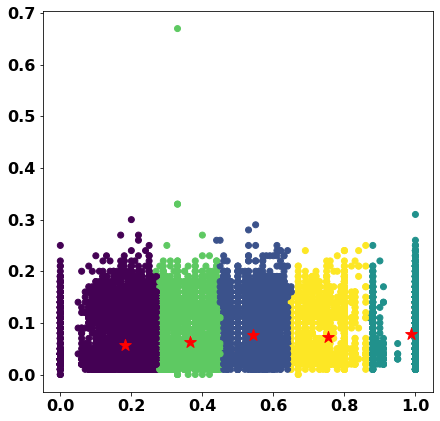

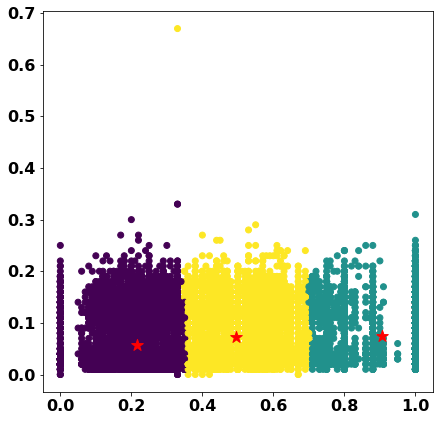

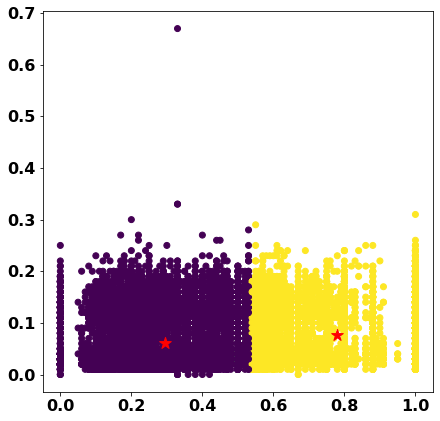

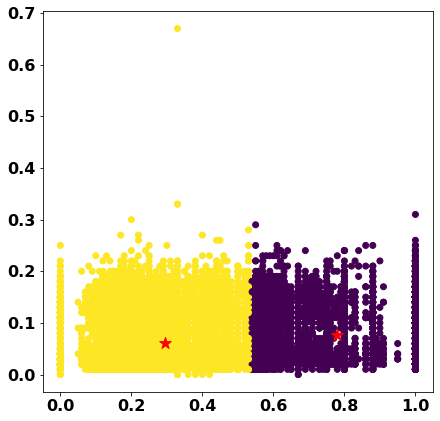

In [23]:
from sklearn.cluster import KMeans, SpectralClustering

estimators = [
    ("k_means_iris_5", KMeans(n_clusters=5, max_iter=100)),
    ("k_means_iris_3", KMeans(n_clusters=3, max_iter=100)),
    ("k_means_iris_2", KMeans(n_clusters=2, max_iter=100)),
    ("k_means_iris_bad_init", KMeans(n_clusters=2, max_iter=100,n_init=1, init="random")),
]

fignum = 1
titles = ['5 Clusters','3 Clusters','2 Clusters', '2 clusters with Bad Init.']
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(7,7))
    est.fit(X_ctrain)
    centroids = est.cluster_centers_
    labels = est.labels_
    y_pred = est.predict(X_ctest)
    plt.scatter(X_ctrain[:,1], X_ctrain[:,0], c=labels)
    plt.scatter(centroids[:, 1], centroids[:, 0], marker='*', s=150,
            c='r', label='centroid')
    fignum = fignum + 1
    print(y_pred)

In [24]:
pred=pd.DataFrame(y_pred)
pred.value_counts()

1    4084
0    1950
dtype: int64

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score

ac_c = accuracy_score(y_ctest,y_pred)
cm_c = confusion_matrix(y_ctest, y_pred)
print(ac_c)
print(cm_c)

0.23467020218760357
[[ 161 2829]
 [1789 1255]]


### Naive Bayes Classifier

In [2]:
nb_training=pd.read_parquet('training_df.parquet')
nb_training.head(3)

,zalando,aboutyou,fuzz_score,fuzz_score_title,status
0,b33f55d6-0149-4063-8b63-3eeae63562a2,ad5ceb87-0254-4171-b650-1d4d09f48efc,0.12,0.80,1
1,f04bef4a-f771-4749-914c-1b22718523b8,b68dd42a-9bda-46e2-aa4e-3d7c50881bb2,0.03,0.43,1
2,396c292a-cda8-4477-ac67-86701fc8ab95,7d19213c-b3ea-406a-ac8e-8299823c7bb4,0.04,0.26,1


In [3]:
nb_training=nb_training.drop(index=nb_training.index[15170:22669]).reset_index().drop(columns='index',axis=1)

In [7]:
nb_testing=testing
nb_testing=nb_testing.drop(columns=['zal_offer_id','ay_offer_id'], axis=1)
nb_testing.head(3)

,fuzz_score_description,fuzz_score_title
0,0.01,1.0
1,0.02,1.0
2,0.02,1.0


In [8]:
nb_testing=nb_testing.reset_index().drop(columns='index',axis=1)
nb_testing

,fuzz_score_description,fuzz_score_title
0,0.01,1.00
1,0.02,1.00
2,0.02,1.00
3,0.04,1.00
4,0.04,1.00
...,...,...
5658,0.19,0.35
5659,0.20,0.25
5660,0.04,0.50
5661,0.18,0.50


In [9]:
nb_testing=nb_testing.drop(index=nb_testing.index[0:799])

In [10]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
X = nb_training.iloc[:, [2, 3]].values
y = nb_training.iloc[:, -1].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score

ac = accuracy_score(y_test,y_pred)
cm = confusion_matrix(y_test, y_pred)
pc = precision_score(y_test,y_pred)
rc = recall_score(y_test, y_pred)

print('Accuracy Score:',ac)
print('Precision Score:',pc)
print('Recall Score:',rc)

Accuracy Score: 0.8474090407938258
Precision Score: 0.9027921406411582
Recall Score: 0.8646417959722681


In [11]:
import sklearn
print(sklearn.metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78      1506
           1       0.90      0.86      0.88      3029

    accuracy                           0.85      4535
   macro avg       0.83      0.84      0.83      4535
weighted avg       0.85      0.85      0.85      4535



<AxesSubplot:>

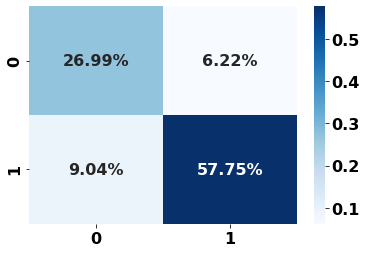

In [12]:
import seaborn as sns
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

#### Prediction of the X_test

In [13]:
ypred=pd.DataFrame(y_pred)
ypred.value_counts()

1    2901
0    1634
dtype: int64

#### Prediction of our generated dataset

In [14]:
y_pred_1=classifier.predict(nb_testing)
ypred_1=pd.DataFrame(y_pred_1)
ypred_1.value_counts()

1    2726
0    2138
dtype: int64

In [15]:
ypred_1=ypred_1.rename(columns={0:'status'})

In [16]:
final_test=pd.concat([testing,ypred_1],axis=1)

In [17]:
final_test['status'].value_counts()

1.0    2726
0.0    2138
Name: status, dtype: int64

In [18]:
final_test=final_test.drop(columns=['fuzz_score_description','fuzz_score_title'], axis=1).dropna()
final_test

,zal_offer_id,ay_offer_id,status
0,37d0d991-4264-4dce-9980-17bde9d7b984,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,1.0
1,a81b5fe2-97e3-48db-a9cc-782e7ad0154a,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,1.0
2,275f7ed3-8107-47f9-ade2-dc9018547ced,f76f3710-6c7f-4dc9-b9f1-0dbad109315d,1.0
3,8cc376c8-23a7-447b-9fa0-15914bd27e09,38bae5e1-1cb0-4fd3-ab8b-397a692b7d7a,1.0
4,8cc376c8-23a7-447b-9fa0-15914bd27e09,89bc00e1-b35e-4264-b64b-9e96dcb90d12,1.0
...,...,...,...
4859,78190b84-b6c0-43b6-b74f-08cdd0834359,c8a5ef85-12bb-4341-a05c-635ee76d49ef,1.0
4860,78190b84-b6c0-43b6-b74f-08cdd0834359,d88e1c3a-abb9-43ba-b0c2-56a4da3dda05,1.0
4861,78190b84-b6c0-43b6-b74f-08cdd0834359,ced539db-0c13-45e8-8e03-e12155ecb994,1.0
4862,78190b84-b6c0-43b6-b74f-08cdd0834359,18c5821b-618f-450a-b376-1b130aca5034,1.0


In [19]:
final_test.to_parquet( 'matches_test_predicted.parquet' )